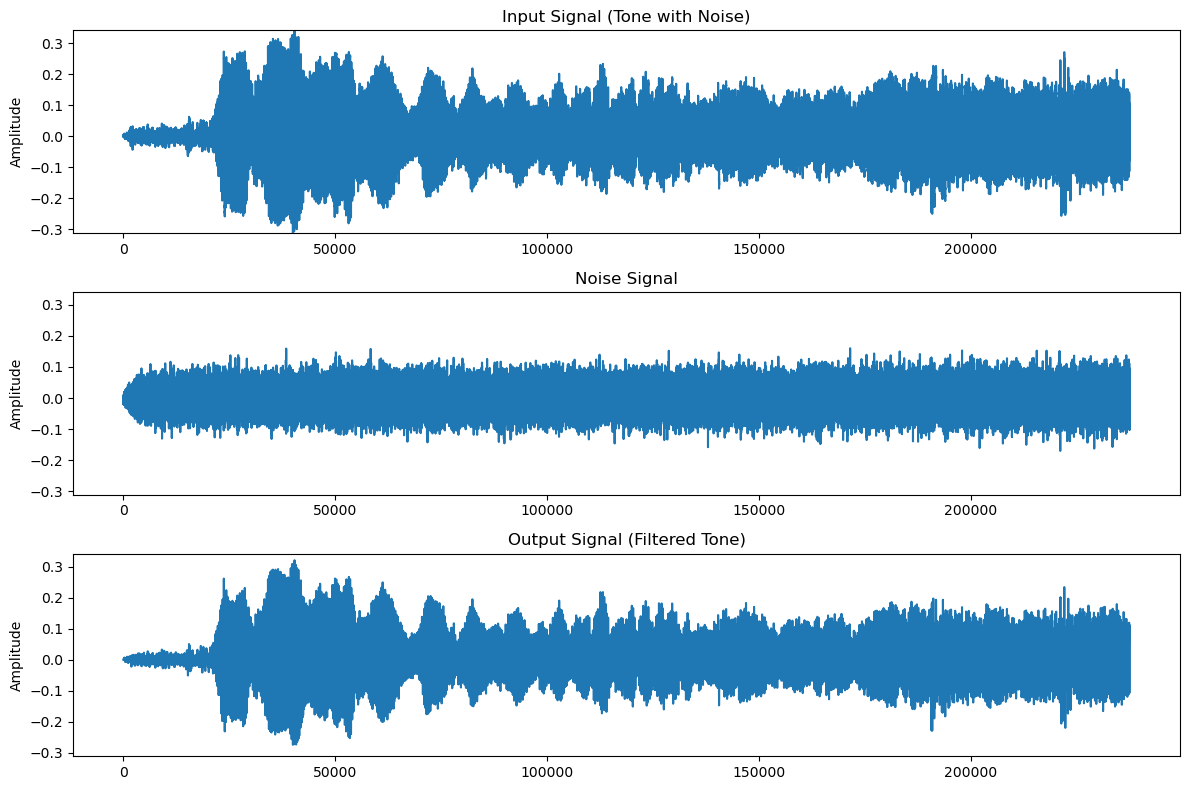

In [4]:
import tkinter as tk
from tkinter import filedialog
from tkinter import messagebox
import numpy as np
import soundfile as sf
import os
import matplotlib.pyplot as plt
import winsound

class NoiseReductionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("LMS NoisePurify")
        self.root.geometry("800x600")
        self.root.configure(bg="#1C2833")

        # 標題標籤
        self.label = tk.Label(root, text="LMS NoisePurify", font=("Helvetica", 28, "bold"), bg="#1C2833", fg="#FDFEFE")
        self.label.pack(pady=20)

        # 載入文件按鈕
        self.load_button = tk.Button(root, text="Load Tone with Noise File", command=self.load_input_file, font=("Helvetica", 14, "bold"), bg="#2874A6", fg="#FDFEFE", activebackground="#1A5276", activeforeground="#FDFEFE", bd=0, padx=20, pady=10)
        self.load_button.pack(pady=10)

        # 載入噪聲文件按鈕
        self.noise_button = tk.Button(root, text="Load Noise File", command=self.load_noise_file, font=("Helvetica", 14, "bold"), bg="#2874A6", fg="#FDFEFE", activebackground="#1A5276", activeforeground="#FDFEFE", bd=0, padx=20, pady=10)
        self.noise_button.pack(pady=10)

        # 處理按鈕
        self.process_button = tk.Button(root, text="Process", command=self.process_audio, font=("Helvetica", 14, "bold"), bg="#148F77", fg="#FDFEFE", activebackground="#117A65", activeforeground="#FDFEFE", bd=0, padx=20, pady=10)
        self.process_button.pack(pady=20)

        # 播放輸入信號按鈕
        self.play_input_button = tk.Button(root, text="Play Input Signal", command=self.play_input_signal, font=("Helvetica", 14, "bold"), bg="#AF7AC5", fg="#FDFEFE", activebackground="#884EA0", activeforeground="#FDFEFE", bd=0, padx=20, pady=10)
        self.play_input_button.pack(pady=10)

        # 播放和顯示波形按鈕
        self.play_button = tk.Button(root, text="Play and Show Waveforms", command=self.play_output_file, font=("Helvetica", 14, "bold"), bg="#E74C3C", fg="#FDFEFE", activebackground="#922B21", activeforeground="#FDFEFE", bd=0, padx=20, pady=10)
        self.play_button.pack(pady=10)

        self.input_file = None
        self.noise_file = None
        self.output_file = None
        self.input_signal = None
        self.noise_signal = None
        self.output_signal = None

        self.temp_input_file = "temp_input_signal.wav"

    def load_input_file(self):
        self.input_file = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
        if self.input_file:
            messagebox.showinfo("File Selected", f"Selected file: {self.input_file}")

    def load_noise_file(self):
        self.noise_file = filedialog.askopenfilename(filetypes=[("WAV files", "*.wav")])
        if self.noise_file:
            messagebox.showinfo("File Selected", f"Selected file: {self.noise_file}")

    def process_audio(self):
        if not self.input_file or not self.noise_file:
            messagebox.showerror("Error", "Please select both input and noise files.")
            return

        self.input_signal, fs = sf.read(self.input_file)
        self.noise_signal, _ = sf.read(self.noise_file)

        # 確保信號是一維陣列
        if self.input_signal.ndim > 1:
            self.input_signal = self.input_signal[:, 0]
        if self.noise_signal.ndim > 1:
            self.noise_signal = self.noise_signal[:, 0]

        # 確保訊號長度一致
        min_length = min(len(self.input_signal), len(self.noise_signal))
        self.input_signal = self.input_signal[:min_length]
        self.noise_signal = self.noise_signal[:min_length]

        # 創建含噪信號
        noisy_signal = self.input_signal

        # 增加濾波器階數和調整步長參數
        filter_order = 128  # 增加濾波器階數
        step_size = 0.0005  # 調整步長參數
        lms_filter = LMSFilter(filter_order, step_size)

        desired_signal = self.input_signal
        self.output_signal, error_signal = lms_filter.adapt(desired_signal, noisy_signal)

        # 多重濾波器處理
        for _ in range(3):  # 重複濾波多次以增強降噪效果
            self.output_signal, error_signal = lms_filter.adapt(self.output_signal, noisy_signal)

        self.output_file = os.path.join(os.path.dirname(self.input_file), 'output_signal.wav')
        sf.write(self.output_file, self.output_signal, fs)

        # 保存輸入信號到臨時文件
        sf.write(self.temp_input_file, self.input_signal, fs)

        messagebox.showinfo("Processing Complete", f"Output file saved as: {self.output_file}")

    def play_input_signal(self):
        if not self.input_file:
            messagebox.showerror("Error", "No input file to play. Please load an input file first.")
            return

        winsound.PlaySound(self.temp_input_file, winsound.SND_FILENAME)

    def play_output_file(self):
        if not self.output_file:
            messagebox.showerror("Error", "No output file to play. Please process an audio file first.")
            return

        winsound.PlaySound(self.output_file, winsound.SND_FILENAME)

        self.show_waveforms()

    def show_waveforms(self):
        plt.figure(figsize=(12, 8))

        plt.subplot(3, 1, 1)
        plt.plot(self.input_signal)
        plt.title('Input Signal (Tone with Noise)')
        plt.ylabel('Amplitude')
        plt.ylim(min(self.input_signal), max(self.input_signal))

        plt.subplot(3, 1, 2)
        plt.plot(self.noise_signal)
        plt.title('Noise Signal')
        plt.ylabel('Amplitude')
        plt.ylim(min(self.input_signal), max(self.input_signal))  # 使第二個圖表的縱軸與第一個一致

        plt.subplot(3, 1, 3)
        plt.plot(self.output_signal)
        plt.title('Output Signal (Filtered Tone)')
        plt.ylabel('Amplitude')
        plt.ylim(min(self.input_signal), max(self.input_signal))  # 使第三個圖表的縱軸與第一個一致

        plt.tight_layout()
        plt.show()

class LMSFilter:
    def __init__(self, filter_order, step_size):
        self.filter_order = filter_order
        self.step_size = step_size
        self.weights = np.zeros(filter_order)

    def adapt(self, desired, input_signal):
        n = len(input_signal)
        output = np.zeros(n)
        error = np.zeros(n)

        for i in range(self.filter_order, n):
            x = input_signal[i:i-self.filter_order:-1]
            output[i] = np.dot(self.weights, x)
            error[i] = desired[i] - output[i]
            self.weights += 2 * self.step_size * error[i] * x

        return output, error

if __name__ == "__main__":
    root = tk.Tk()
    app = NoiseReductionApp(root)
    root.mainloop()
